## Análisis de los lagos

In [ ]:
#!pip install openeo
#!pip install rasterio
#!pip install sentinelhub

### 1) Establecer conexión con API Sentinel 2

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo

# Conexión al backend que opera sobre Sentinel Hub (Copernicus)
connection = openeo.connect("https://openeo.sentinel-hub.com/production/")
connection.authenticate_basic("TU_CLIENT_ID", "TU_CLIENT_SECRET")

### 2) Descargar imagenes .tif usando las coordenadas

In [ ]:
coords_atitlan = {
    "west": -91.326256, 
    "south": 14.5948, 
    "east": -91.07151, 
    "north": 14.750979
    }

coords_amatitlan = {
    "west": -90.638065, 
    "south": 14.412347, 
    "east": -90.512924, 
    "north": 14.493799
    }

### 3) Seleccionar periodo de observación 

In [ ]:
cube_atitlan = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=coords_atitlan, #region de Guatemala
    temporal_extent=["2024-01-01", "2024-06-30"],
    bands=["B04","B05","B06","B08","B11","B12"]  # incluye bandas necesarias para cianobacterias
)

cube_amatitlan = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=coords_amatitlan,
    temporal_extent=["2024-01-01", "2024-06-30"],
    bands=["B04","B05","B06","B08","B11","B12"]
)

### 4) Aplicar el script de detección de cianobacterias 

Todo este proceso se realizó en el browser de Sentinel 2 y se descargaron las imagenes en la carpeta "img"

### 6) Convertir los .tif a arreglos numpy

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.signal import find_peaks

carpeta_tif = "."
resultados = []

# --- Leer imágenes ---
for archivo in os.listdir(carpeta_tif):
    if archivo.lower().endswith((".tif", ".tiff")):
        ruta = os.path.join(carpeta_tif, archivo)
        with rasterio.open(ruta) as src:
            img = src.read(1).astype(float)
            nodata = src.nodata
            if nodata is not None:
                img = np.where(img == nodata, np.nan, img)
            promedio = np.nanmean(img)

        # Extraer nombre y fecha
        nombre_sin_ext = archivo.rsplit(".", 1)[0]
        for i, c in enumerate(nombre_sin_ext):
            if c.isdigit():
                lago = nombre_sin_ext[:i]
                fecha_str = nombre_sin_ext[i:]
                break
        fecha = datetime.strptime(fecha_str, "%Y-%m-%d")

        resultados.append({
            "Lago": lago.capitalize(),
            "Fecha": fecha,
            "Promedio": promedio
        })

# --- Crear DataFrame ---
df = pd.DataFrame(resultados).sort_values(by=["Lago", "Fecha"])


### Indice promedio, evolución temporal y posibles picos de floración de la cianobacteria

In [ ]:
# --- Detectar picos relativos ---
picos_lista = []
plt.figure(figsize=(10, 6))

for lago, datos in df.groupby("Lago"):
    datos = datos.sort_values("Fecha")
    fechas = datos["Fecha"].to_numpy()
    valores = datos["Promedio"].to_numpy()

    # Detectar picos
    idx_picos, _ = find_peaks(valores)
    picos_fecha = fechas[idx_picos]
    picos_valor = valores[idx_picos]

    # Guardar picos detectados
    for f, v in zip(picos_fecha, picos_valor):
        picos_lista.append({"Lago": lago, "Fecha": f, "Promedio": v})

    # Graficar línea
    plt.plot(fechas, valores, marker="o", label=lago)
    # Marcar picos
    plt.scatter(picos_fecha, picos_valor, color="red", zorder=5)

plt.xlabel("Fecha")
plt.ylabel("Índice promedio de cianobacteria")
plt.title("Evolución temporal y picos detectados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Mostrar tabla de picos ---
picos_df = pd.DataFrame(picos_lista)
print("\nPicos de floración detectados:")
print(picos_df)

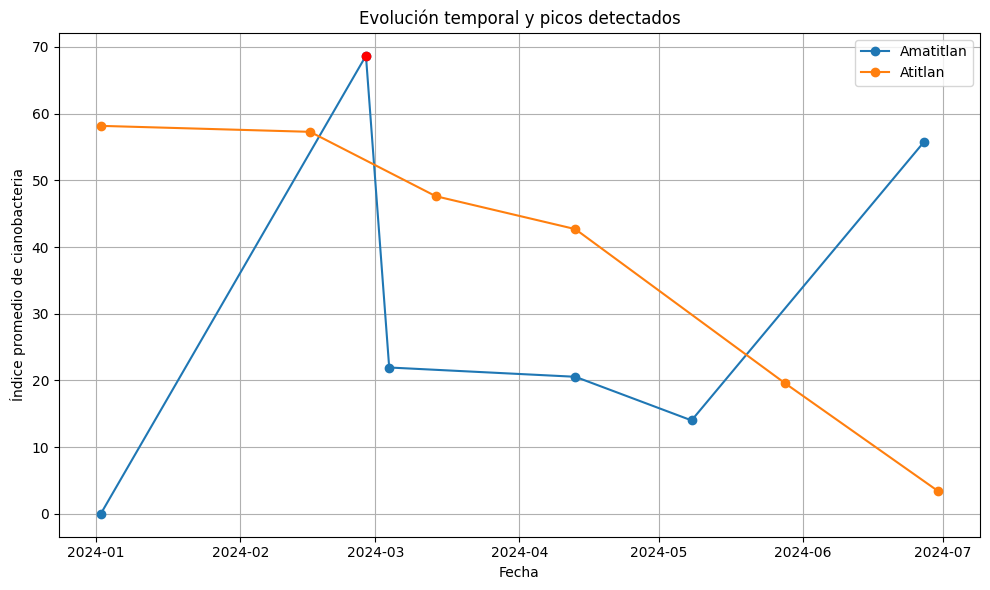
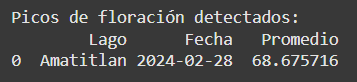